Iteration: 0, Loss: 8.452075958251953
Iteration: 500, Loss: 1.9003204107284546
Iteration: 1000, Loss: 1.4781619310379028
Iteration: 1500, Loss: 1.4990429878234863
Iteration: 2000, Loss: 1.1702960729599
Iteration: 2500, Loss: 1.5622729063034058
Iteration: 3000, Loss: 1.2274041175842285
Iteration: 3500, Loss: 1.0161428451538086
Iteration: 4000, Loss: 1.0335885286331177
Iteration: 4500, Loss: 1.1686527729034424
Iteration: 5000, Loss: 0.9706630110740662
Iteration: 5500, Loss: 1.0383806228637695
Iteration: 6000, Loss: 1.0454554557800293
Iteration: 6500, Loss: 0.7583590745925903
Iteration: 7000, Loss: 0.9054500460624695
Iteration: 7500, Loss: 0.8269357085227966
Iteration: 8000, Loss: 0.6555413007736206
Iteration: 8500, Loss: 0.6218206286430359
Iteration: 9000, Loss: 0.8293058276176453
Iteration: 9500, Loss: 0.7722707390785217


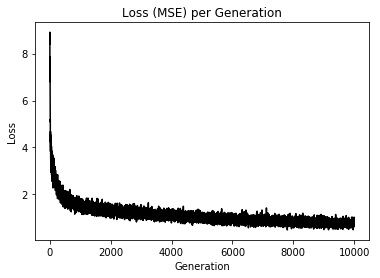

[6]


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import random
import numpy as np
from tensorflow.python.framework import ops
ops.reset_default_graph()

response = 6
batch_size = 50
symmetry = ["rotate180", "rotate90", "rotate270", "flip_v", "flip_h"]

def print_board(board):
    symbols = ['0', ' ', 'X']
    board_plus1 = [int(x) + 1 for x in board]
    print(' ' + symbols[board_plus1[0]] + ' | ' + symbols[board_plus1[1]] + ' | ' + symbols[board_plus1[2]])
    print("___________")
    print(' ' + symbols[board_plus1[3]] + ' | ' + symbols[board_plus1[4]] + ' | ' + symbols[board_plus1[5]])
    print("___________")
    print(' ' + symbols[board_plus1[6]] + ' | ' + symbols[board_plus1[7]] + ' | ' + symbols[board_plus1[8]])
    
def get_symmetry(board, response, transformation):
    if transformation == 'rotate180':
        new_response = 8 - response
        return board[::-1], new_response
    elif transformation == 'rotate90':
        new_response = [6, 3, 0, 7, 4, 1, 8, 5, 2].index(response)
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))
        return [value for item in tuple_board for value in item], new_response
    elif transformation == 'rotate270':
        new_response = [2, 5, 8, 1, 4, 7, 0, 3, 6].index(response)
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]
        return [value for item in tuple_board for value in item], new_response
    elif transformation == 'flip_v':
        new_response = [6, 7, 8, 3, 4, 5, 0, 1, 2].index(response)
        return board[6:9] + board[3:6] + board[0:3], new_response
    elif transformation == 'flip_h':
        new_response = [2, 1, 0, 5, 4, 3, 8, 7, 6].index(response)
        new_board = board[::-1]
        return new_board[6:9] + new_board[3:6] + new_board[0:3], new_response
    else:
        raise ValueError('해당하는 경우가 없습니다!')

def get_moves_from_csv(csv_file):
    moves = []
    with open(csv_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            moves.append(([int(x) for x in row[0:9]], int(row[9])))
    return moves

def get_rand_move(moves, rand_transforms=2):
    (board, play_response) = random.choice(moves)
    possible_transforms = ['rotate90', 'rotate180', 'rotate270', 'flip_v', 'flip_h']
    for _ in range(rand_transforms):
        random_transform = random.choice(possible_transforms)
        (board, play_response) = get_symmetry(board, play_response, random_transform)
    return board, play_response

moves = get_moves_from_csv('base_tic_tac_toe_moves.csv')

train_length = 500
train_set = []
for t in range(train_length):
    train_set.append(get_rand_move(moves))
    
test_board = [-1, 0, 0, 1, -1, -1, 0, 0, 1]
train_set = [x for x in train_set if x[0] != test_board]

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape))

def model(X, A1, A2, bias1, bias2):
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X, A1), bias1))
    layer2 = tf.add(tf.matmul(layer1, A2), bias2)
    return layer2

X = tf.placeholder(dtype=tf.float32, shape=[None, 9])
Y = tf.placeholder(dtype=tf.int32, shape=[None])

A1 = init_weights([9, 81])
bias1 = init_weights([81])
A2 = init_weights([81, 9])
bias2 = init_weights([9])

model_output = model(X, A1, A2, bias1, bias2)

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=Y))
train_step = tf.train.GradientDescentOptimizer(0.025).minimize(loss)
prediction = tf.argmax(model_output, 1)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

loss_vec = []
for i in range(10000):
    rand_indices = np.random.choice(range(len(train_set)), batch_size, replace=False)
    batch_data = [train_set[i] for i in rand_indices]
    x_input = [x[0] for x in batch_data]
    y_target = np.array([y[1] for y in batch_data])
    sess.run(train_step, feed_dict={X: x_input, Y: y_target})
    
    temp_loss = sess.run(loss, feed_dict={X: x_input, Y: y_target})
    loss_vec.append(temp_loss)
    if i % 500 == 0:
        print('Iteration: {}, Loss: {}'.format(i, temp_loss))

plt.plot(loss_vec, 'k-', label='Loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

test_boards = [test_board]
feed_dict = {X: test_boards}
logits = sess.run(model_output, feed_dict=feed_dict)
predictions = sess.run(prediction, feed_dict=feed_dict)
print(predictions)

def check(board):
    wins = [[0, 1, 2], [3, 4, 5], [6, 7, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 4, 8], [2, 4, 6]]
    for ix in range(len(wins)):
        if board[wins[ix][0]] == board[wins[ix][1]] == board[wins[ix][2]] == 1.:
            return 1
        elif board[wins[ix][0]] == board[wins[ix][1]] == board[wins[ix][2]] == -1.:
            return -1
    return 0

In [39]:
game_tracker = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
win_logical = False
num_moves = 0

while not win_logical:
    player_index = input('수 입력 (0-8): ')
    if game_tracker[int(player_index)] != 0.:
        print("돌이 있으니까 딴데 둬라.")
        continue
    num_moves += 1
    
    game_tracker[int(player_index)] = 1.
    [potential_moves] = sess.run(model_output, feed_dict={X: [game_tracker]})
    allowed_moves = [ix for ix, x in enumerate(game_tracker) if x == 0.0]
    model_move = np.argmax([x if ix in allowed_moves else -999.0 for ix, x in enumerate(potential_moves)])
    
    game_tracker[int(model_move)] = -1.
#     print('Model has moved')
    print_board(game_tracker)

    if check(game_tracker) == 1:
        print("승리!")
        win_logical = True
    elif check(game_tracker) == -1 or num_moves >= 5:
        print("패배...")
        win_logical = True

수 입력 (0-8): 1
   | X | 0
___________
   |   |  
___________
   |   |  
수 입력 (0-8): 4
   | X | 0
___________
   | X |  
___________
 0 |   |  
수 입력 (0-8): 8
   | X | 0
___________
   | X | 0
___________
 0 |   | X
수 입력 (0-8): 3
 0 | X | 0
___________
 X | X | 0
___________
 0 |   | X
수 입력 (0-8): 7
 0 | X | 0
___________
 X | X | 0
___________
 0 | X | X
승리!


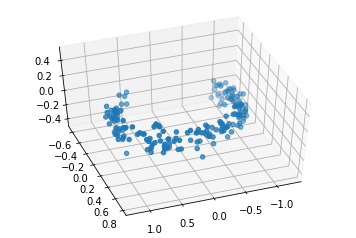

In [42]:
import tensorflow as tf
import numpy.random as rnd
import numpy as np
rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
ax = plt.axes(projection = '3d')
ax.scatter3D(data[:, 0], data[:, 1], data[:, 2])
ax.view_init(azim=70, elev=50)

In [43]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

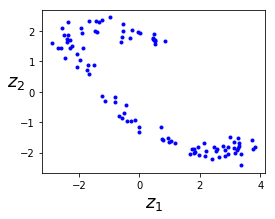

In [46]:
reset_graph()
n_inputs = 3
n_hidden = 2
n_outputs = n_inputs
learning_rate = 0.01
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
init = tf.global_variables_initializer()

n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X:X_train})
    codings_val = codings.eval(feed_dict={X:X_test})
    
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:,1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.savefig("선형 AE")
plt.show()

In [54]:
# autoencoder
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.gridspec as gridspec
def vis(images, save_name):
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
    gs = gridspec.GridSpec(n_image_rows, n_image_cols, top=1., bottom=0.,
                          right=1., left=0., hspace=0., wspace=0.)
    for g, count in zip(gs, range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count,:].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.savefig(save_name+'_vis.png')
    plt.show()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 111353.14
1 96698.09
2 87417.766
3 80848.83
4 76819.805
5 74261.984
6 71154.7
7 70272.086
8 68194.414
9 68107.266
10 67903.484
11 65344.863
12 66495.48
13 64207.56
14 64599.953
15 65801.13
16 63333.645
17 62951.86
18 62340.65
19 62248.9
20 62699.773
21 61580.137
22 61053.89
23 61927.754
24 61443.277
25 61471.145
26 60492.207
27 60422.72
28 61464.25
29 59430.43
30 59902.055
31 60153.18
32 58785.9
33 59058.875
34 60208.875
35 59649.43
36 59079.273
37 58265.203
38 58851.234
39 59388.89
40 59129.746
41 58796.734
42 58924.895
43 58630.934
44 58715.188
45 58651.78
46 58342.797
47 57351.086
48 57749.37
49 58585.035
50 57257.4
51 58316.88
52 57039.555
53 57726.805
54 58023.38
55 57817.305
56 57359.727
57 57614.695
58 56843.242
59 56657.793
60 56987.258
61 57477.85
62 56823.953
63 56294.39
64 56942.297

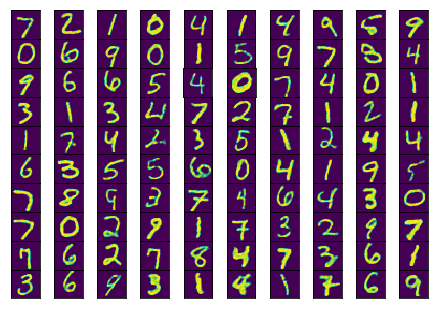

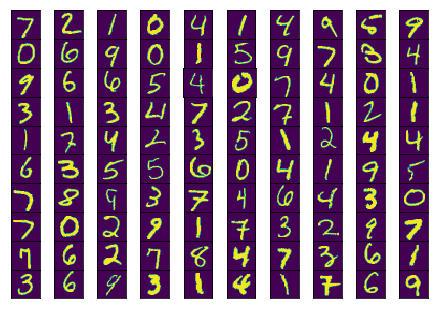

Done


In [55]:
mnist_width = 28
n_visible = mnist_width * mnist_width
n_hidden = 500
corruption_level = 0.3
X = tf.placeholder("float", [None, n_visible], name='X')
mask = tf.placeholder("float", [None, n_visible], name="mask")
W_init_max = 4 * np.sqrt(6. / (n_visible + n_hidden))
W_init = tf.random_uniform(shape=[n_visible, n_hidden], minval=-W_init_max,
                          maxval=W_init_max)
W = tf.Variable(W_init, name='W')
b = tf.Variable(tf.zeros([n_hidden]), name='b')

W_prime = tf.transpose(W)
b_prime = tf.Variable(tf.zeros([n_visible]), name="b_prime")
def model(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask * X
    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)
    return Z
Z = model(X, mask, W, b, W_prime, b_prime)
cost = tf.reduce_sum(tf.pow(X - Z, 2))
train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost)
predict_op = Z
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

with tf.Session() as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()

    for i in range(100):
        for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
            input_ = trX[start:end]
            mask_np = np.random.binomial(1, 1 - corruption_level, input_.shape)
            sess.run(train_op, feed_dict={X: input_, mask: mask_np})

        mask_np = np.random.binomial(1, 1 - corruption_level, teX.shape)
        print(i, sess.run(cost, feed_dict={X: teX, mask: mask_np}))
    # save the predictions for 100 images
    mask_np = np.random.binomial(1, 1 - corruption_level, teX[:100].shape)
    predicted_imgs = sess.run(predict_op, feed_dict={X: teX[:100], mask: mask_np})
    input_imgs = teX[:100]
    # plot the reconstructed images
    vis(predicted_imgs,'pred')
    vis(input_imgs,'in')
    print('Done')